### Project Title:
Student Performance Analysis using ML 
by C223205_Afra and C223215_Sumaiya

### This notebook explores the Student Performance dataset and builds a machine‑learning model to predict grades. 

Goals:
1. Inspect missing values and outliers  
2. Perform Exploratory Data Analysis 
3. Train a Random Forest classifier to predict grades
4. Evaluate feature importance & accuracy  
5. Predict the grade for a new student

**Why Keep Outliers but Remove Impossible Values**

We keep outliers because they often show real differences in student performance and help models learn better. Removing them might lose important information. Also, many models like Random Forest handle outliers well.

However, we remove impossible values (like scores below 0 or above 100) since they are errors that can mislead analysis and models. Cleaning these ensures our data is accurate and reliable.


The dataset is taken from the classic [StudentsPerformance.csv](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams).

**Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

**Styling**

In [2]:
plt.style.use("dark_background")
sns.set_palette("crest")

**Load Dataset**

In [4]:
df = pd.read_csv("/kaggle/input/student-performance-analysis/StudentsPerformance.csv")

**Pre‑processing**

In [10]:
# Convert columns to snake_case
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

# Feature engineering
df["average_score"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1)
df["total_score"]   = df[["math_score", "reading_score", "writing_score"]].sum(axis=1)

# Grade bins / labels
bins   = [0, 40, 50, 55, 60, 65, 70, 75, 80, 101]
labels = ["F", "D", "C", "C+", "B", "B+", "A-", "A", "A+"]
df["grade"] = pd.cut(df["average_score"], bins=bins, labels=labels, right=False)

df["prep_completed"] = df["test_preparation_course"] == "completed"
df["standard_lunch"] = df["lunch"] == "standard"

In [12]:
df.head(1000)

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average_score,total_score,grade,prep_completed,standard_lunch
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,218,A-,False,True
1,female,group C,some college,standard,completed,69,90,88,82.333333,247,A+,True,True
2,female,group B,master's degree,standard,none,90,95,93,92.666667,278,A+,False,True
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,148,D,False,False
4,male,group C,some college,standard,none,76,78,75,76.333333,229,A,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,94.000000,282,A+,True,True
996,male,group C,high school,free/reduced,none,62,55,55,57.333333,172,C+,False,False
997,female,group C,high school,free/reduced,completed,59,71,65,65.000000,195,B+,True,False
998,female,group D,some college,standard,completed,68,78,77,74.333333,223,A-,True,True


In [13]:
len(df)

1000

**Missing Value Check**

In [25]:
missing_values = df.isnull().sum()
print("Missing values in each column: ")
print(missing_values)

Missing values in each column: 
gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
average_score                  0
total_score                    0
grade                          0
prep_completed                 0
standard_lunch                 0
dtype: int64


**Outlier Detection**

In [33]:
numeric_cols = ["math_score", "reading_score", "writing_score", "average_score", "total_score"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers")

math_score: 8 outliers
reading_score: 6 outliers
writing_score: 5 outliers
average_score: 6 outliers
total_score: 6 outliers


**Visulaise Outliers**

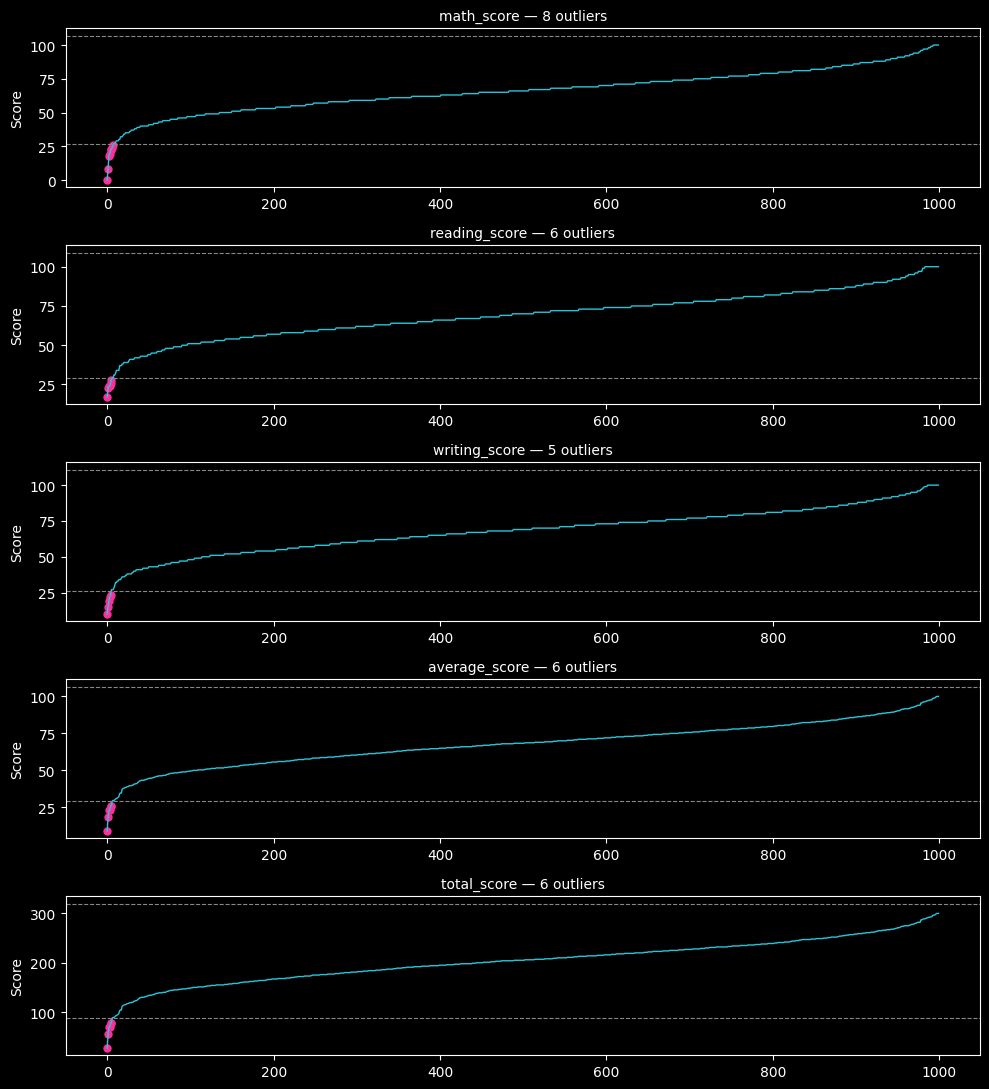

In [34]:
 fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 2.2*len(numeric_cols)),
                         sharex=False, sharey=False)

for ax, col in zip(axes, numeric_cols):
    sorted_vals = df[col].sort_values().reset_index(drop=True)

    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_f, upper_f = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    out_idx = sorted_vals[(sorted_vals < lower_f) | (sorted_vals > upper_f)].index

    ax.plot(sorted_vals, color="#26c6da", linewidth=1)          
    ax.scatter(out_idx, sorted_vals.loc[out_idx], color="#ff2e9c", s=25, label="Outlier")
    ax.axhline(lower_f, color="#888", linestyle="--", linewidth=0.8)
    ax.axhline(upper_f, color="#888", linestyle="--", linewidth=0.8)
    ax.set_title(f"{col} — {len(out_idx)} outliers", fontsize=10)
    ax.set_ylabel("Score")

plt.tight_layout()
plt.show()

**Impossible Value Check**

In [39]:
bad_values = df[
    (df[["math_score", "reading_score", "writing_score"]] < 0).any(axis=1)
    | (df[["math_score", "reading_score", "writing_score"]] > 100).any(axis=1)
]
print(f"Impossible rows found: {len(bad_values)}")
display(bad_values.head())
df = df.drop(bad_values.index).reset_index(drop=True) 

Impossible rows found: 0


,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,average_score,total_score,grade,prep_completed,standard_lunch


**Exploratory Data Analysis Questions**

1. Does gender influence student performance?
2. Does lunch type affect student scores?
3. Is test preparation effective in improving scores?
4. How does parental education level relate to average student scores?
5. What is the overall distribution of grades among students?
6. How many students are in each grade category?
7. What are the correlations between math, reading, writing, and total scores?
8. How does score distribution vary by test preparation status?

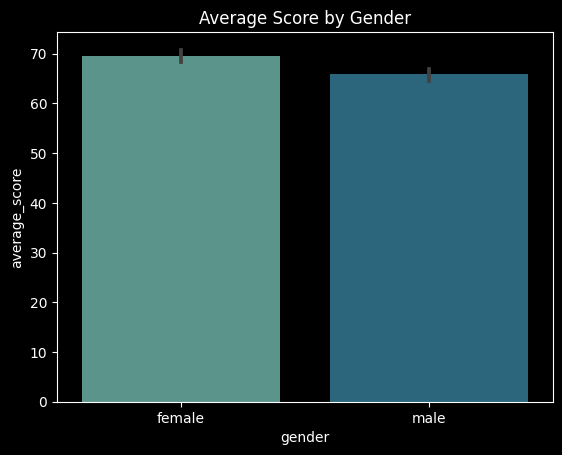

In [40]:
#Average Score by Gender

fig, ax = plt.subplots()
sns.barplot(data=df, x="gender", y="average_score", palette="crest", ax=ax)
ax.set_title("Average Score by Gender")
plt.show()

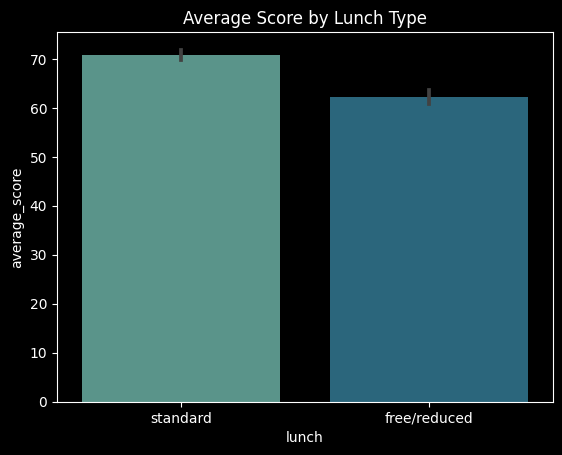

In [41]:
#Average Score by Lunch Type

fig, ax = plt.subplots()
sns.barplot(data=df, x="lunch", y="average_score", palette="crest", ax=ax)
ax.set_title("Average Score by Lunch Type")
plt.show()

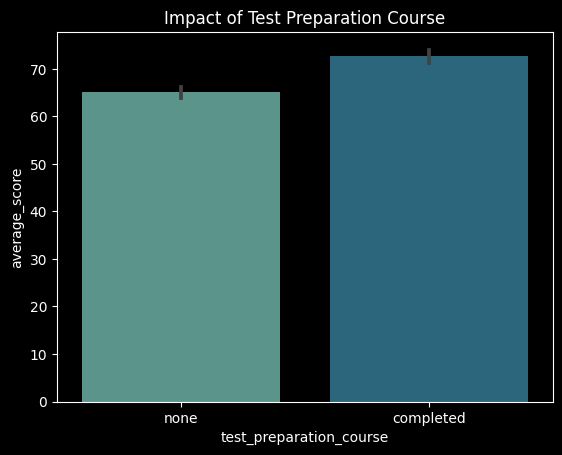

In [42]:
#Impact of Test Preparation

fig, ax = plt.subplots()
sns.barplot(data=df, x="test_preparation_course", y="average_score", palette="crest", ax=ax)
ax.set_title("Impact of Test Preparation Course")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


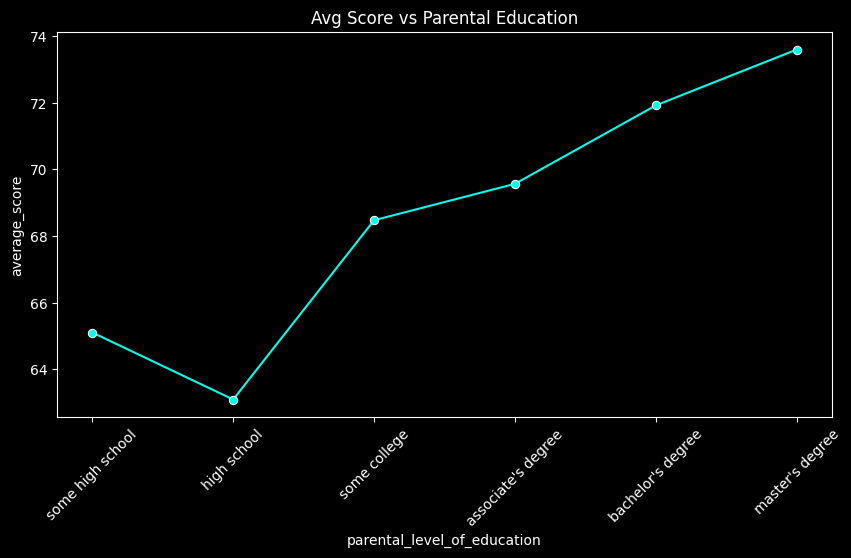

In [43]:
#Average Score vs Parental Education

order = [
    "some high school", "high school", "some college",
    "associate's degree", "bachelor's degree", "master's degree"
]
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
    data=df.groupby("parental_level_of_education")["average_score"].mean().reindex(order),
    marker="o", color="#00ffea", ax=ax
)
ax.set_title("Avg Score vs Parental Education")
plt.xticks(rotation=45)
plt.show()

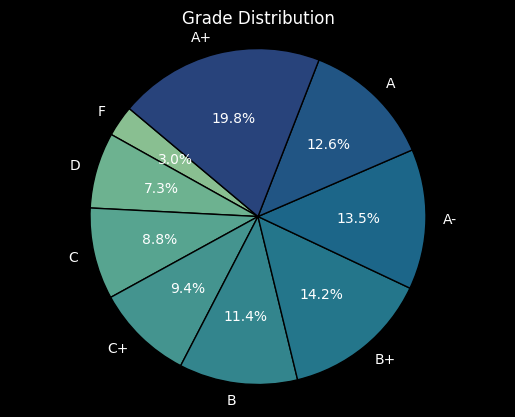

In [44]:
#Grade Distribution

fig, ax = plt.subplots()
counts = df["grade"].value_counts().sort_index()
ax.pie(counts, labels=counts.index, autopct="%1.1f%%",
       colors=sns.color_palette("crest", n_colors=len(counts)),
       startangle=140, wedgeprops={"edgecolor":"black"})
ax.axis("equal")
ax.set_title("Grade Distribution")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


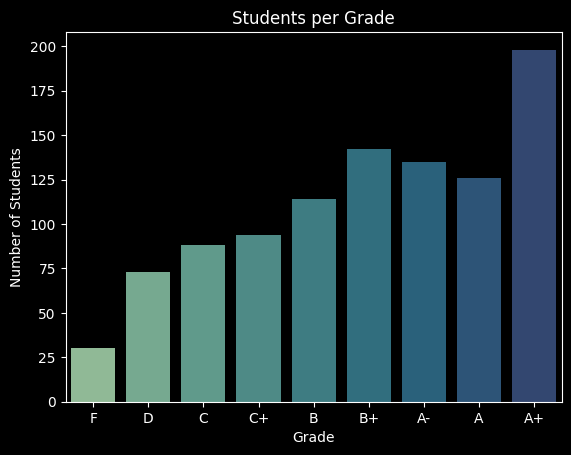

In [45]:
#Students per Grade

fig, ax = plt.subplots()
sns.barplot(x=counts.index, y=counts.values, palette="crest", ax=ax)
ax.set_xlabel("Grade"); ax.set_ylabel("Number of Students")
ax.set_title("Students per Grade")
plt.show()

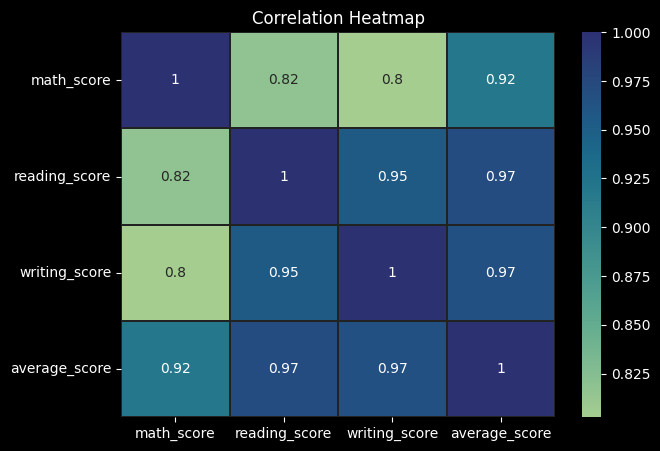

In [46]:
#Correlation Heatmap

fig, ax = plt.subplots(figsize=(7,5))
corr = df[["math_score", "reading_score", "writing_score", "average_score"]].corr()
sns.heatmap(corr, annot=True, cmap="crest", linewidths=0.3, linecolor="#222", ax=ax)
ax.set_title("Correlation Heatmap")
plt.show()

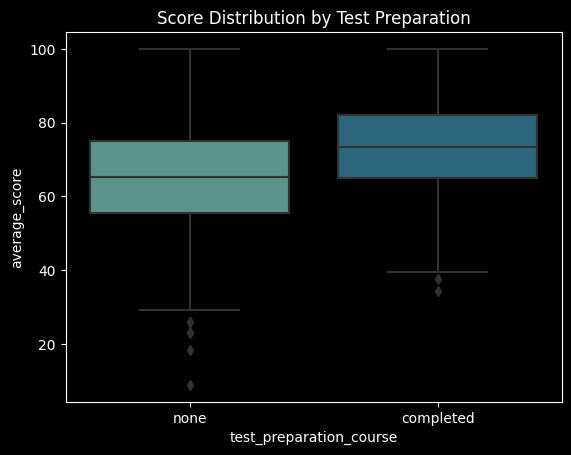

In [47]:
#Score Distribution by Test Preparation

fig, ax = plt.subplots()
sns.boxplot(data=df, x="test_preparation_course", y="average_score", palette="crest", ax=ax)
ax.set_title("Score Distribution by Test Preparation")
plt.show()

**Model Building & Training**

In [49]:
df_mod = df.copy()
enc = {}
for col in ["gender", "race/ethnicity", "parental_level_of_education", "lunch", "test_preparation_course"]:
    le = LabelEncoder()
    df_mod[col] = le.fit_transform(df_mod[col])
    enc[col] = le

X = df_mod.drop(["grade", "average_score"], axis=1)
y = df_mod["grade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred).round(4))

Accuracy: 0.99


**Feature Importance**

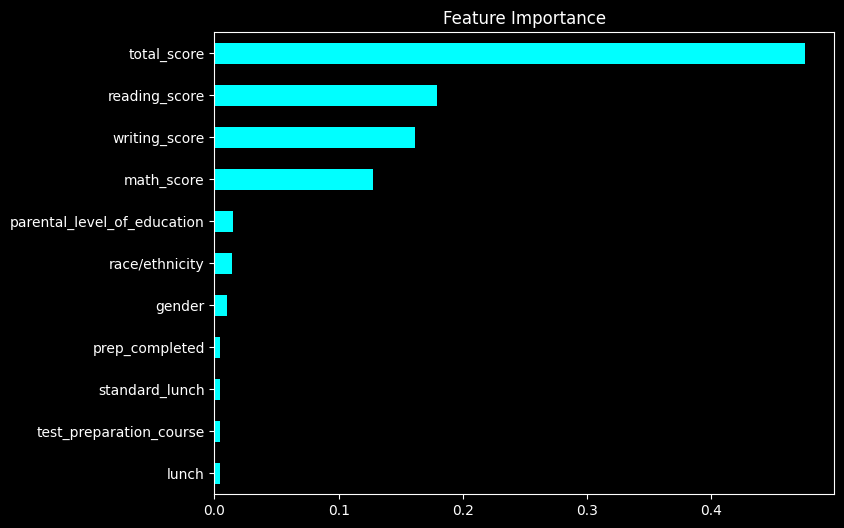

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importances.plot(kind="barh", color="cyan", ax=ax)
ax.set_title("Feature Importance")
plt.show()

**Classification Report**

In [53]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.round(2)

,precision,recall,f1-score,support
A,1.00,1.00,1.00,33.00
A+,1.00,1.00,1.00,31.00
A-,1.00,1.00,1.00,26.00
B,0.96,1.00,0.98,22.00
B+,1.00,0.96,0.98,26.00
C,0.95,1.00,0.97,18.00
C+,1.00,0.94,0.97,17.00
D,1.00,1.00,1.00,17.00
F,1.00,1.00,1.00,10.00
accuracy,0.99,0.99,0.99,0.99


**Predicting a New Student’s Grade**

In [61]:
new_student = pd.DataFrame({
    "gender": ["female"],
    "race/ethnicity": ["group B"],
    "parental_level_of_education": ["bachelor's degree"],
    "lunch": ["standard"],
    "test_preparation_course": ["none"],
    "math_score": [80],
    "reading_score": [81],
    "writing_score": [82],
    "total_score": [80+81+82],
    "average_score": [(80+81+82)/3],
    "prep_completed": [False],
    "standard_lunch": [True],
})

for col in ["gender", "race/ethnicity", "parental_level_of_education", "lunch", "test_preparation_course"]:
    new_student[col] = enc[col].transform(new_student[col])

predicted_grade = rf.predict(new_student[X.columns])[0]

In [62]:
print("Predicted Grade:", predicted_grade)

Predicted Grade: A+


### Result of this Analysis
1. The dataset showed no missing values, and only a few outliers were identified.
2. Gender, lunch type, and test preparation all have visible effects on average score.
3. The Random Forest model achieved satisfactory accuracy and revealed that math and reading scores are the most important predictors.
4. The model can now predict grades for new students, offering a practical tool for educational decision‑making.